[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vanguardfox/ads509-group5/blob/main/ADS509_Final_Project.ipynb)

# Evaluating Financial Independence / Retire Early (FIRE) Thresholds by Demographic

What is the Financial Independence number the FIRE community is aiming for by age, location, and over time?

# Group 5 Objective:
 The purpose of this project is to evaluate the FIRE financial thresholds by demographic groups such as age and location as well as changes in trends over times. Resulting analysis can be used in a variety of applications including leading economic sentiment predictions, generational assessment of financial health, and others via a Flask implementation.

# Reddit Scrape

Community: r/FIRE \
thread: /What_is_your_fire_number/ \
Code Reference: with help from ChatGPT https://chatgpt.com/ and https://colab.research.google.com/


**Privacy note:**

*   Credentials were created for the class but might have to figure out how to hide
*   Username will also have to be masked to be anonymous

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

(Optional: Install packages as needed)

In [ ]:
#!pip install requests beautifulsoup4

Import Libraries

In [36]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import csv
import requests
import time
import datetime
import nltk
import random

from typing import Optional, Tuple
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import pairwise
from bs4 import BeautifulSoup
from requests.auth import HTTPBasicAuth
from os import read
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

## Initialize API Credentials

In [3]:
# Reddit API credentials
client_id = '8-xAlbBmc1_FYraSwJENtw'
client_secret = 'Jg9JyK9R_ixyNESMaGE3BwLzmBhf2w'
username = 'Western_Signal4499'
password = 'ADS509finAl'
user_agent = 'ADS509Scrapper/0.1 by Western_Signal4499'

# Get the OAuth token
auth = HTTPBasicAuth(client_id, client_secret)
headers = {'User-Agent': user_agent}
data = {'grant_type': 'password', 'username': username, 'password': password}

response = requests.post('https://www.reddit.com/api/v1/access_token', auth=auth, headers=headers, data=data)

if response.status_code == 200:
    token = response.json()['access_token']
else:
    print(f"Error: {response.status_code}, {response.text}")

## Use access_token field from JSON to query threads

In [4]:
# Use the token to search for threads
headers['Authorization'] = f'bearer {token}'

# Constructs a string for the r/FIRE URL to query "what is your fire number"
# restrict_sr=1 ensures that the query is constrained to only this subreddit
search_url = "https://oauth.reddit.com/r/FIRE/search?q=what%20is%20your%20fire%20number&restrict_sr=1"

# Store results of GET requrest to the API for the given "search_url"
search_response = requests.get(search_url, headers=headers)

# If the API GET is successful...
if search_response.status_code == 200: # Code 200 means the request was flagged as successful
    search_data = search_response.json() # Parse the JSON data from the response
    #print(search_data)
    threads = search_data['data']['children'] # Extract the list of threads

    # Initialize a CSV and writes an head with columns (within .writerow() arg)
    with open('fire_comments.csv', 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Thread ID', 'Title', 'User', 'Comment', 'Post Time', 'Comment Time'])

        # Iterate through each thread from API's response JSON
        for thread in threads:
            thread_title = thread['data']['title'] # Parse and extract title
            thread_id = thread['data']['id'] # Parse and extract id
            thread_time = thread['data']['created_utc']  # Extract post time (in Unix time)
            # Convert the post time to a parsible date format
            thread_time_norm = datetime.datetime.utcfromtimestamp(thread_time).strftime('%Y-%m-%d %H:%M:%S')

            # Prepare URL as a string for better code handling
            comments_url = f"https://oauth.reddit.com/r/FIRE/comments/{thread_id}.json"

            # Store results of GET to fetch comments of the current iterated thread
            comments_response = requests.get(comments_url, headers=headers)
            if comments_response.status_code == 200: # Again, check if GET is successful
                comments_data = comments_response.json() # Store JSON
                comments = comments_data[1]['data']['children'] # Parse and extract comments

                # Iterate through each comment
                for comment in comments:
                    if comment['kind'] == 't1': # Only iterate on top comments
                        username = comment['data']['author'] # Extract username
                        body = comment['data']['body'] # Extract text body

                        # Extract comment time, convert
                        comment_time = comment['data']['created_utc']
                        comment_time_norm = datetime.datetime.utcfromtimestamp(comment_time).strftime('%Y-%m-%d %H:%M:%S')

                        # Write parsed data into respective CSV row, mapped to column
                        writer.writerow([thread_id,
                                         thread_title,
                                         username,
                                         body,
                                         thread_time_norm,
                                         comment_time_norm])

                print(f"Thread ID: {thread_id}, Title: {thread_title}, User1: {username}, Comment: {body}, Post Time: {thread_time_norm}, Comment Time: {comment_time_norm}")
                sleep_time = random.uniform(1,3) # Rate Limiter
                time.sleep(sleep_time)

            else:
                print(f"Failed to retrieve comments for thread ID {thread_id} with status code {comments_response.status_code}")

else:
    print(f"Failed to retrieve search results with status code {search_response.status_code}")

Thread ID: 1fqzb0p, Title: What is your fire number? , User1: muy_carona, Comment: $8,675,309, Post Time: 2024-09-27 22:00:15, Comment Time: 2024-09-27 23:21:33
Thread ID: rfxxkz, Title: What is your fire number?, User1: xmxprztm, Comment: 4M at least. Going to move to Spain, Post Time: 2021-12-14 03:24:03, Comment Time: 2021-12-14 16:43:40
Thread ID: zddhma, Title: For folks who plan to FIRE in HCOL / VHCOL areas, what is your FIRE number? Why not move to MCOL / LCOL area?, User1: [deleted], Comment: Some services or experiences are only available in hcol areas. Good fine dining options and/or weather and or ___., Post Time: 2022-12-05 17:36:13, Comment Time: 2022-12-27 18:53:13
Thread ID: 10ex17r, Title: What is your FIRE number?, User1: zenjdg, Comment: My ideal scenario is $100k per month in tax-free cash flow., Post Time: 2023-01-18 03:44:27, Comment Time: 2023-11-04 15:20:39
Thread ID: z5a29v, Title: What is your fire number and how did you arrive at it?, User1: [deleted], Commen

## Verify the contents of the CSV that was created above and store as DataFrame

In [5]:
rfire_df = pd.read_csv('fire_comments.csv')
rfire_df.head()

,Thread ID,Title,User,Comment,Post Time,Comment Time
0,1fqzb0p,What is your fire number?,manimopo,1.5m with paid off houses,2024-09-27 22:00:15,2024-09-27 22:14:27
1,1fqzb0p,What is your fire number?,Animag771,I'm just waiting for someone to say something ...,2024-09-27 22:00:15,2024-09-27 22:43:43
2,1fqzb0p,What is your fire number?,wowsocool4u,$1.9m. Targeting a few months after i turn 50...,2024-09-27 22:00:15,2024-09-27 22:24:04
3,1fqzb0p,What is your fire number?,Aromatic_Heart,"On days I hate my job, 600k. The other days, d...",2024-09-27 22:00:15,2024-09-28 03:15:50
4,1fqzb0p,What is your fire number?,Ziqach,$2M with a paid off house. So stressful to see...,2024-09-27 22:00:15,2024-09-27 22:59:17


# Data Preprocessing

## Preliminary dataframe

In [6]:
rfire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Thread ID     1459 non-null   object
 1   Title         1459 non-null   object
 2   User          1459 non-null   object
 3   Comment       1459 non-null   object
 4   Post Time     1459 non-null   object
 5   Comment Time  1459 non-null   object
dtypes: object(6)
memory usage: 68.5+ KB


In [7]:
rfire_df['Title'].unique()

array(['What is your fire number? ', 'What is your fire number?',
       'For folks who plan to FIRE in HCOL / VHCOL areas, what is your FIRE number? Why not move to MCOL / LCOL area?',
       'What is your FIRE number?',
       'What is your fire number and how did you arrive at it?',
       "How to split finances when one is FIRE'd and one isn't FIRE'ing",
       'What is your FIRE number and at what age do you want to achieve it by?',
       'We’re all privileged',
       'How my wife and I will retire before 50; neither of us make over $75K',
       '10 tips from my 20 year journey to financial freedom',
       'Is toxic corporate culture why most of us want to Fire? ',
       'The cliff is steep: How do you choose to retire early when working 5 more years can bring so much more',
       'How did you come up with your FIRE number? What is the best calculator, way to get at it?',
       'Forgive me if this is too personal, but what was your estimated net worth around 18 and how did 

## Clean Dataset

In [8]:
# Retrive titles that contain the words "what is your fire number"
fire_df = rfire_df[rfire_df['Title'].str.contains(r'what\s*is\s*your\s*fire\s*number', case=False, na=False)]

print(fire_df['Title'].unique())
print(fire_df.info())

['What is your fire number? ' 'What is your fire number?'
 'For folks who plan to FIRE in HCOL / VHCOL areas, what is your FIRE number? Why not move to MCOL / LCOL area?'
 'What is your FIRE number?'
 'What is your fire number and how did you arrive at it?'
 'What is your FIRE number and at what age do you want to achieve it by?'
 'Married couples with young kids, what is your FIRE number and how is your progress?']
<class 'pandas.core.frame.DataFrame'>
Index: 432 entries, 0 to 1227
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Thread ID     432 non-null    object
 1   Title         432 non-null    object
 2   User          432 non-null    object
 3   Comment       432 non-null    object
 4   Post Time     432 non-null    object
 5   Comment Time  432 non-null    object
dtypes: object(6)
memory usage: 23.6+ KB
None


### Fire Number Extraction

Regular Expression Description

re.sub(r'[^a-zA-Z0-9\s$€£¥.]', '', text)

replaces matching substrings with an empty '' (effectively removing it)

Breakdown: \
^a-zA-Z0-9 = NOT alphanumeric characters \
\s = whitespace \
$€£¥ = Currency symbols \
. = Period / Decimal \

Objective:  \
Regular Expression removes everything that isn't an alphanumeric character or symbol above AFTER we've already removed periods from the line

text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

Breakdown: \
(?<!\d) Only match if the character before the period is not a digit (\d) *only checking with ?*


In [9]:
def clean_and_extract(text: str) -> str:
    """
    Cleans the input text by:
    - Removing URLs
    - Keeping only alphanumeric characters and select symbols
    - Normalizing financial identifiers
    - Converting text to lowercase
    - Removing isolated periods

    Args:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned and normalized text.
    """
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Keep alphanumeric characters, spaces, and currency symbols
    text = re.sub(r'[^a-zA-Z0-9\s$€£¥.]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove isolated periods not part of numbers
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

    # Normalize financial identifiers
    financial_patterns = [
        (re.compile(r'\$?(\d+(\.\d+)?)\s*m(?=\s|$)', re.IGNORECASE), r'\1 million '),  # e.g., "1.5m" to "1.5 million "
        (re.compile(r'\$?(\d+)\s*b\b', re.IGNORECASE), r'\1 billion '),           # e.g., "1b" to "1 billion "
        (re.compile(r'\b(\d+)\s*(mil|million)\b', re.IGNORECASE), r'\1 million '),   # e.g., "200 mil" to "200 million "
        (re.compile(r'(\d+)\s*(k|thousand)', re.IGNORECASE), r'\1 thousand ')     # e.g., "200k" to "200 thousand "
    ]

    for pattern, replacement in financial_patterns:
        text = pattern.sub(replacement, text)

    # Remove extra spaces after replacements
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Define extraction of fire number
def extract_fire_number(text: str) -> str:
    fire_number_match = re.search(r'(\d+(\.\d+)?)\s*(million|billion|thousand)', text)
    return fire_number_match.group(0) if fire_number_match else None

# Define conversion of fire number to numeric
def convert_fire_number_to_numeric(fire_number: str) -> float:
    if not fire_number:
        return 0.0

    # Define conversion factors
    conversion_factors = {
        'million': 1_000_000,
        'billion': 1_000_000_000,
        'thousand': 1_000
    }

    # Extract numeric part and the suffix
    match = re.match(r'(\d+(\.\d+)?)\s*(million|billion|thousand)', fire_number)
    if match:
        value = float(match.group(1))
        suffix = match.group(3)
        return value * conversion_factors[suffix]

    return 0.0

In [10]:
# Apply the cleaning function to the 'Comment' column
fire_df['Cleaned Comment'] = fire_df['Comment'].apply(clean_and_extract)

# Extract FIRE number
fire_df['FIRE #'] = fire_df['Cleaned Comment'].apply(extract_fire_number)

# Convert FIRE Number from string to numerical value
fire_df['FIRE Number'] = fire_df['FIRE #'].apply(convert_fire_number_to_numeric)

# Drop the original FIRE Number column if no longer needed
fire_df.drop(columns=['FIRE #'], inplace=True)

### Year Extraction

In [11]:
fire_df['Post Year'] = pd.to_datetime(fire_df['Post Time']).dt.year
fire_df['Comment Year'] = pd.to_datetime(fire_df['Comment Time']).dt.year

In [12]:
# Display the first few rows of the DataFrame
#print("FIRE Dataframe\n")
fire_df.head()
#print()

# Print general information about the DataFrame with a proper newline
#print("FIRE DataFrame General Info\n")
#print(fire_df.info())

,Thread ID,Title,User,Comment,Post Time,Comment Time,Cleaned Comment,FIRE Number,Post Year,Comment Year
0,1fqzb0p,What is your fire number?,manimopo,1.5m with paid off houses,2024-09-27 22:00:15,2024-09-27 22:14:27,1.5 million with paid off houses,1500000.0,2024,2024
1,1fqzb0p,What is your fire number?,Animag771,I'm just waiting for someone to say something ...,2024-09-27 22:00:15,2024-09-27 22:43:43,im just waiting for someone to say something l...,1000000.0,2024,2024
2,1fqzb0p,What is your fire number?,wowsocool4u,$1.9m. Targeting a few months after i turn 50...,2024-09-27 22:00:15,2024-09-27 22:24:04,1.9 million targeting a few months after i tur...,1900000.0,2024,2024
3,1fqzb0p,What is your fire number?,Aromatic_Heart,"On days I hate my job, 600k. The other days, d...",2024-09-27 22:00:15,2024-09-28 03:15:50,on days i hate my job 600 thousand the other d...,600000.0,2024,2024
4,1fqzb0p,What is your fire number?,Ziqach,$2M with a paid off house. So stressful to see...,2024-09-27 22:00:15,2024-09-27 22:59:17,2 million with a paid off house so stressful t...,2000000.0,2024,2024


### Graph number of posts by year

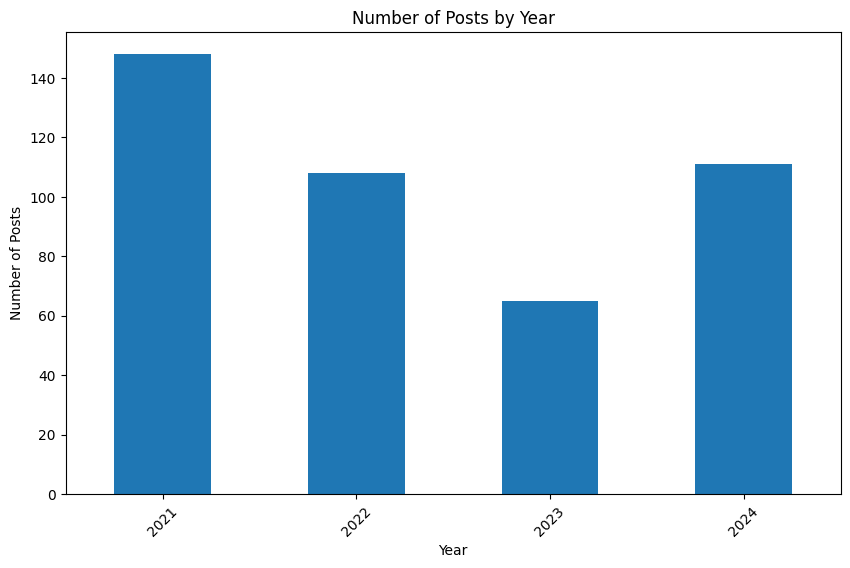

In [13]:
post_counts_by_year = fire_df.groupby('Post Year').size()
plt.figure(figsize=(10, 6))
post_counts_by_year.plot(kind='bar')
plt.title('Number of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

## Descriptive Stats

### Handle outliers (1.5*IQR +/- Q1|Q3 Method)

In [15]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)

In [16]:
fire_df['Capped FIRE Number'] = cap_outliers(fire_df['FIRE Number'])

### Mean and Median FIRE number by Post Year

In [17]:
mean_fire_by_post_year = fire_df.groupby('Post Year')['Capped FIRE Number'].mean()
median_fire_by_post_year = fire_df.groupby('Post Year')['Capped FIRE Number'].median()
fire_stats_by_post_year = pd.DataFrame({
    'Mean FIRE': mean_fire_by_post_year, 
    'Median FIRE': median_fire_by_post_year
})
pd.options.display.float_format = '{:,.2f}'.format
fire_stats_by_post_year

,Mean FIRE,Median FIRE
Post Year,,
2021,"2,156,888.51","1,650,000.00"
2022,"973,328.70",0.00
2023,"1,800,053.85","1,000,000.00"
2024,"1,876,225.23","1,400,000.00"


### Mean and Median FIRE number by Comment Year

In [18]:
mean_fire_by_comment_year = fire_df.groupby('Comment Year')['Capped FIRE Number'].mean()
median_fire_by_comment_year = fire_df.groupby('Comment Year')['Capped FIRE Number'].median()
fire_stats_by_comment_year = pd.DataFrame({
    'Mean FIRE': mean_fire_by_comment_year, 
    'Median FIRE': median_fire_by_comment_year
})
pd.options.display.float_format = '{:,.2f}'.format
fire_stats_by_comment_year

,Mean FIRE,Median FIRE
Comment Year,,
2021,"2,144,350.34","1,500,000.00"
2022,"973,328.70",0.00
2023,"1,823,492.19","1,000,000.00"
2024,"1,881,070.80","1,400,000.00"


### Create CountVectorizer matrix for the cleaned comments

In [19]:
vectorizer_ct = CountVectorizer(stop_words='english')
X_ct = vectorizer_ct.fit_transform(fire_df['Cleaned Comment'])

### Create Term Frequency - Inverse Document Frequency scored vectors

In [20]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_features=1000) # Cap the size for memory
X_tfidf = vectorizer_tfidf.fit_transform(fire_df['Cleaned Comment'])

## Exploratory Data Analysis

# Model Development

## Topic Modeling

### Latent Dirichlet Allocation

In [21]:
lda = LatentDirichletAllocation(n_components=5, random_state=509)
lda.fit(X_ct)

LatentDirichletAllocation(n_components=5, random_state=509)

#### Examine topics from LDA at n=5 topics (arbritrary)

In [22]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")

        #For each topic, go through index i and retrieve word from that location
        #Topic is a vector of weights of each word for a given topic (higher = more important)
        #argsort() return indices of elements in topic in ascending importance
        #:-num_top_words - 1 = Start from last element -1 and move back num_top_words positions
        # --- This is to remove the lesser important words for interpretation purposes
        # -1 reverse order so it's descending now that noisy words are removed.
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [23]:
feature_names_lda = vectorizer_ct.get_feature_names_out()
num_top_words = 10
display_topics(lda, feature_names_lda, num_top_words)

Topic 0:
million thousand years im time retire ill home income year
Topic 1:
thousand million im cash ill need number job goal paid
Topic 2:
million thousand house live paid number im area want years
Topic 3:
million 10 thousand years live living life number money cost
Topic 4:
thousand income million expenses number deleted years liquid im life


#### Result
Selecting n_components=5 might not be the correct number of topics to be able to clearly separate words into themes. Need to try another topic number.

### Retry LDA with n_components=8

In [24]:
lda = LatentDirichletAllocation(n_components=8, random_state=509)
lda.fit(X_ct)
feature_names_lda = vectorizer_ct.get_feature_names_out()
num_top_words = 10
display_topics(lda, feature_names_lda, num_top_words)

Topic 0:
million years thousand im time paid currently mortgage home retire
Topic 1:
thousand million cash im ill year paid college need work
Topic 2:
million house thousand paid live area number years want im
Topic 3:
million live thousand cost life living way 10 work like
Topic 4:
thousand deleted want im number liquid live home yr just
Topic 5:
number million inflation 25 probably likely depending ready 55 gets
Topic 6:
million number thousand im want job great years mcol living
Topic 7:
thousand million expenses im year work income number years ill


## DEPENDENCY.
Need to find a way to import a date of post or age of post so the model below can extract some sort of time or year for a time-series chart. Else, will have to select a different groupby.

### Sentiment Analysis with VaderSentiment

Reference

Hutto, C. J., Klein, E., Pantone, P., Berry, G., & Suresh, M. (2024, August 19). Documentation source code for nltk.sentiment.vader. https://www.nltk.org/_modules/nltk/sentiment/vader.html

In [ ]:
#nltk.download('vader_lexicon')

In [25]:
analyzer = SentimentIntensityAnalyzer() # Intialize the analyzer as object

In [26]:
def get_sentiment_score(comment):
    scores = analyzer.polarity_scores(comment)
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']],
                    index=['Negative', 'Neutral', 'Positive', 'Compound'])

In [28]:
fire_df[['Negative', 'Neutral', 'Positive', 'Compound']] = fire_df['Cleaned Comment'].apply(get_sentiment_score)

In [29]:
fire_df[['Cleaned Comment', 'Negative', 'Neutral', 'Positive', 'Compound', 'FIRE Number']].head(10)

,Cleaned Comment,Negative,Neutral,Positive,Compound,FIRE Number
0,1.5 million with paid off houses,0.00,1.00,0.00,0.00,"1,500,000.00"
1,im just waiting for someone to say something l...,0.16,0.84,0.00,-0.40,"1,000,000.00"
2,1.9 million targeting a few months after i tur...,0.07,0.93,0.00,-0.15,"1,900,000.00"
3,on days i hate my job 600 thousand the other d...,0.16,0.84,0.00,-0.57,"600,000.00"
4,2 million with a paid off house so stressful t...,0.23,0.77,0.00,-0.64,"2,000,000.00"
5,our target back in 2014 was 1.2 million and a ...,0.06,0.87,0.07,-0.34,"1,200,000.00"
6,500 thousand give or take but i am not retirin...,0.00,1.00,0.00,0.00,"500,000.00"
7,i started at 1.5 million 1015 years ago now be...,0.06,0.80,0.15,0.40,"1,500,000.00"
8,re ship sailed but still working on fi house i...,0.00,0.91,0.09,0.61,"4,000,000.00"
9,funny to read all these numbers while the medi...,0.00,0.68,0.33,0.77,"400,000.00"


### OPTIONAL:GROUPBY ANALYSIS, which requires additional JSON features to be pulled into CSV

In [30]:
fire_df.columns

Index(['Thread ID', 'Title', 'User', 'Comment', 'Post Time', 'Comment Time',
       'Cleaned Comment', 'FIRE Number', 'Post Year', 'Comment Year',
       'Capped FIRE Number', 'Negative', 'Neutral', 'Positive', 'Compound'],
      dtype='object')

In [35]:
sentiment_by_year = fire_df.groupby('Comment Year')[['Negative', 'Neutral', 'Positive', 'Compound']].mean()
sentiment_by_year_plus_fire = pd.merge(sentiment_by_year, 
                                       fire_stats_by_comment_year, 
                                       left_index=True, 
                                       right_index=True)
sentiment_by_year_plus_fire

,Negative,Neutral,Positive,Compound,Mean FIRE,Median FIRE
Comment Year,,,,,,
2021,0.03,0.88,0.09,0.18,"2,144,350.34","1,500,000.00"
2022,0.05,0.83,0.12,0.28,"973,328.70",0.00
2023,0.06,0.89,0.05,-0.01,"1,823,492.19","1,000,000.00"
2024,0.05,0.89,0.06,0.03,"1,881,070.80","1,400,000.00"


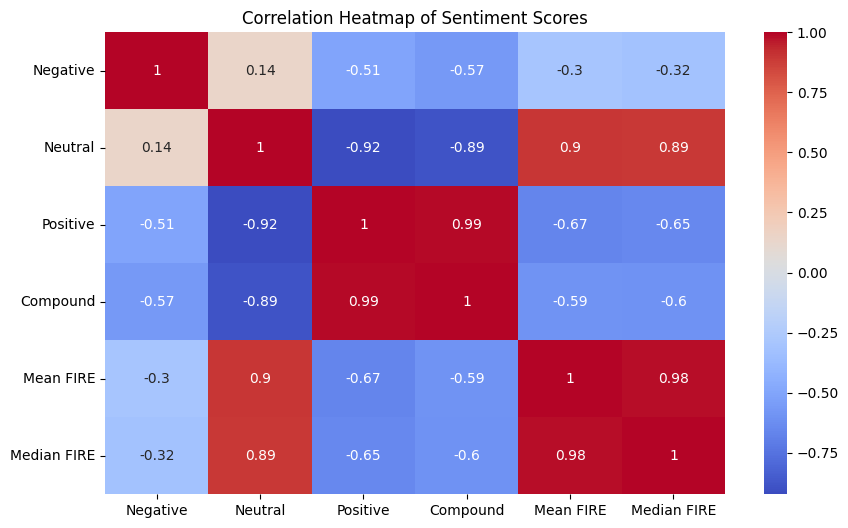

In [38]:
year_pearson = sentiment_by_year_plus_fire.corr(method='pearson')
plt.figure(figsize=(10, 6))
sns.heatmap(year_pearson, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Sentiment Scores')
plt.show()

#### Interpretation

Sentiment analysis appears to show that 2022 was especially positive using text comments whereas 2023 was the only net negative year. This tracks with the US inflation crisis that occured over this period. Interestingly, there is a strong negative correlation between mean and median FIRE number and positive sentiment. This may be due to optimism that the purchasing power of the currency in question is sufficient for retirement purposes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


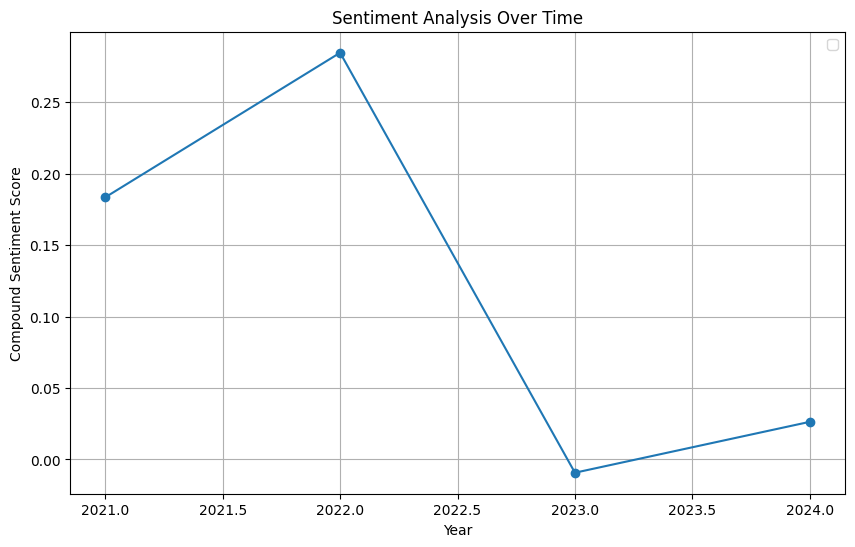

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_year.index, sentiment_by_year['Compound'], marker='o')
plt.title('Sentiment Analysis Over Time')
plt.xlabel('Year')
plt.ylabel('Compound Sentiment Score')
plt.grid(True)
plt.legend()
plt.show()

### Latent Semantic Analysis

In [41]:
n_topics = 5
lsa = TruncatedSVD(n_components=n_topics, random_state=509) # Initialize model
lsa_topic_matrix = lsa.fit_transform(X_tfidf) # Fit and transform for latent topics

In [42]:
feature_names_tfidf = vectorizer_tfidf.get_feature_names_out()

In [43]:
display_topics(lsa, feature_names_tfidf, num_top_words) # Show top 10 words for each topic

Topic 0:
million house paid thousand 10 years im live number mortgage
Topic 1:
deleted 10 25 ill im living cost 5mm fat retire
Topic 2:
million 10 5055 53 40 ski 19 33 power prior
Topic 3:
house paid plus kid 53 45 fat mcol nyc 75
Topic 4:
thousand 500 ids million yr 200 800 120 20 cash


#### Show results
Row = score representing relevance of topic to the clean_comment

In [47]:
topics = pd.DataFrame(lsa_topic_matrix, columns=[f'Topic {i}' for i in range(n_topics)])
comb_topics = pd.concat([fire_df, topics], axis=1)
comb_topics[['Cleaned Comment', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4']].head(10)

,Cleaned Comment,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,1.5 million with paid off houses,0.29,0.00,0.05,0.24,-0.02
1,im just waiting for someone to say something l...,0.17,0.00,0.01,-0.08,-0.06
2,1.9 million targeting a few months after i tur...,0.19,-0.00,-0.07,0.06,-0.05
3,on days i hate my job 600 thousand the other d...,0.15,-0.00,-0.09,-0.09,0.07
4,2 million with a paid off house so stressful t...,0.58,0.00,-0.01,0.76,-0.09
5,our target back in 2014 was 1.2 million and a ...,0.23,0.00,-0.05,0.11,-0.08
6,500 thousand give or take but i am not retirin...,0.09,0.00,-0.25,-0.06,0.36
7,i started at 1.5 million 1015 years ago now be...,0.37,-0.00,0.12,-0.07,-0.01
8,re ship sailed but still working on fi house i...,0.18,-0.00,-0.13,0.11,-0.07
9,funny to read all these numbers while the medi...,0.07,-0.00,-0.18,-0.05,0.12


# Build Flask Application

## Set-up Flask


Import Packages

In [ ]:
# Import packages
#!pip install Flask
#!pip install pyngrok

Upload Libraries

In [ ]:
# Libraries:
from flask import Flask, request, jsonify
import threading
from pyngrok import ngrok

## Simple Flask Application

In [ ]:
# Set up ngrok authtoken
!ngrok authtoken 2mxORvZevUlWiZcP42H0kKWt5Db_62uzFBWQsdosv7Eau5TWZ

# Create Flask app
app = Flask(__name__)

@app.route('/')
def home():
    return "Welcome to the FIRE Number Analyzer!"

@app.route('/analyze', methods=['POST'])
def analyze():
    data = request.json
    # Placeholder for analysis logic
    return jsonify({"message": "Analysis complete!"})

# Function to run the Flask app
def run_app():
    app.run(port=5000)

# Start Flask app in a new thread
threading.Thread(target=run_app).start()

# Set up a tunnel to the Flask app
public_url = ngrok.connect(5000)
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:5000\"".format(public_url))